In [1]:
import itertools
import numpy as np
import pandas as pd
import plotnine
from plotnine import *
import torch
from transformers import AutoModelForMaskedLM, AutoTokenizer

from captum.attr import visualization as viz
from captum.attr import Saliency
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer

plotnine.options.figure_size = (12, 12)
import warnings
warnings.filterwarnings("ignore")

In [38]:
transformer = "distilbert-base-cased"
#transformer = "roberta-base"
#transformer = "twmkn9/bert-base-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(transformer)
model = AutoModelForMaskedLM.from_pretrained(transformer)
model.eval()
model.zero_grad()

In [39]:
def printgradnorm(self, grad_input, grad_output):
    print('Inside ' + self.__class__.__name__ + ' backward')
    print('')
    print('grad_input: ', type(grad_input), len(grad_input))
    print('grad_input[0]: ', type(grad_input[0]))
    print('grad_output: ', type(grad_output), len(grad_output))
    print('grad_output[0]: ', type(grad_output[0]))
    print('')
    print('grad_input size:', grad_input[0].size())
    print('grad_output size:', grad_output[0].size())
    print('grad_input norm:', grad_input[0].norm())
layer = getattr(model.distilbert.transformer.layer, "3")
print(layer)
hook_handle = layer.register_backward_hook(printgradnorm)
print(hook_handle)

TransformerBlock(
  (attention): MultiHeadSelfAttention(
    (dropout): Dropout(p=0.1, inplace=False)
    (q_lin): Linear(in_features=768, out_features=768, bias=True)
    (k_lin): Linear(in_features=768, out_features=768, bias=True)
    (v_lin): Linear(in_features=768, out_features=768, bias=True)
    (out_lin): Linear(in_features=768, out_features=768, bias=True)
  )
  (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (ffn): FFN(
    (dropout): Dropout(p=0.1, inplace=False)
    (lin1): Linear(in_features=768, out_features=3072, bias=True)
    (lin2): Linear(in_features=3072, out_features=768, bias=True)
  )
  (output_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
)


In [3]:
def prepare_data_for_sentence(sent, N):
    input_seq = tokenizer.encode(sent)

    mask_index = input_seq.index(tokenizer.mask_token_id)
#    print(mask_index)

    input_tensor = torch.tensor([input_seq])

    input_result = model.forward(input_tensor, return_dict=True)

    input_result.logits.shape

    token_logits = input_result.logits
    mask_token_logits = token_logits[0, mask_index, :]
    mask_token_probs = torch.nn.functional.softmax(mask_token_logits, dim=0)

    # get the top predictions for the non-occluded sentence
    top_N = torch.topk(mask_token_probs, N, dim=0)
#    print(top_N)
    probs = top_N.values.tolist()
    top_N_tokens = top_N.indices.tolist()
#    print(probs, sum(probs), top_N_tokens)
    return input_seq, top_N_tokens, mask_index

In [36]:
def custom_forward(inputs, attention_mask=None, pos=0):
#    result = model.forward(inputs.double(), return_dict=True, attention_mask=attention_mask)
#    print("POS", pos)
    result = model.forward(inputs, return_dict=True, attention_mask=attention_mask)
    preds = result.logits
#    print("PREDS SHAPE:", preds.shape)
    N_token = preds[:, pos, :]
#()    print("SHAPE", N_token.shape)
    return N_token

def summarize_attributions(attributions):
    print("SUMMARIZE")
    print(attributions.size())
    attributions = attributions.sum(dim=-1).squeeze(0)
    print(attributions.size())
    attributions = attributions / torch.norm(attributions)
    print(attributions.size())
    return attributions

def construct_whole_bert_embeddings(input_ids, ref_input_ids):
    
    input_embeddings = interpretable_embedding.indices_to_embeddings(input_ids)
    #, token_type_ids=token_type_ids, position_ids=position_ids)
    ref_input_embeddings = interpretable_embedding.indices_to_embeddings(ref_input_ids)
    #, token_type_ids=token_type_ids, position_ids=position_ids)

    return input_embeddings, ref_input_embeddings


def run_attribution_model(input_seq, ref_token_id, top_N_tokens, mask_index):
    interpretable_embedding = configure_interpretable_embedding_layer(model, 'distilbert.embeddings')
    try:
        ablator = Saliency(custom_forward)

        input_tensor = torch.tensor([input_seq] * len(top_N_tokens))
#        ref_tensor = torch.tensor([ref_token_id]).expand((1,len(input_seq)))
        interpretable_input_tensor = interpretable_embedding.indices_to_embeddings(input_tensor)
#        ref_tensor = interpretable_embedding.indices_to_embeddings(ref_tensor)

        attention_mask = torch.ones_like(input_tensor)
        attributions = ablator.attribute(
                inputs=interpretable_input_tensor,
#                baselines=ref_tensor,
                abs=False,
                additional_forward_args=(attention_mask,mask_index),
                target=top_N_tokens,
        )
        attributions = summarize_attributions(attributions)
    finally:
        remove_interpretable_embedding_layer(model, interpretable_embedding)

    return attributions.T

In [11]:
def build_dataframe(attributions, input_seq, top_N_tokens):

    ix = pd.CategoricalIndex(
                [tokenizer.decode([token]) for token in input_seq],
                categories=reversed([tokenizer.decode([token]) for token in input_seq]),
                ordered=True
            )
#    print(ix)
    attr_df = (
        pd.DataFrame(
                attributions.detach().numpy(), 
                columns=[tokenizer.decode([token]) for token in top_N_tokens],
                index=ix,
            )
        .reset_index()
    )
    attr_df = attr_df.melt(id_vars=["index"])
    #attr_df = attr_df[~(attr_df['index'] == tokenizer.mask_token)]
    attr_df['variable'] = pd.Categorical(
            attr_df['variable'], 
            categories = [tokenizer.decode([token]) for token in top_N_tokens], 
            ordered=True
        )
    attr_df['display_value'] = attr_df['value'].apply(lambda f: f"{f:.2f}")
    return attr_df
    

In [12]:
def create_plot(attr_df, mask_index, N):
    ncol = np.ceil(np.sqrt(N))
    return (ggplot(attr_df, aes(x="index", y="value")) + 
        geom_col(aes(fill="index", colour="index"))  +
        geom_text(aes(y="value/2", label="display_value"), size=10) +
#        geom_label(aes(x = len(input_seq) - mask_index, y= 0, label="variable"), size=13, boxstyle="darrow") +
        scale_x_discrete(drop=False) +
        facet_wrap("~variable", ncol=ncol) +
        coord_flip() +
        labs(
                x="target token",
                y="Captum contribution scores",
#                title="Exploring the contribution of each token to the prediction."
            ) +
        theme(legend_position="none")
    )

In [13]:
def run_and_show(sentence, mask_tokens, reference=[tokenizer.unk_token_id]):
    if isinstance(mask_tokens, int):
        N = mask_tokens
        input_seq, mask_tokens, mask_index = prepare_data_for_sentence(sentence, N)
    else:
        N = len(mask_tokens)
        if isinstance(mask_tokens[0], str):
            mask_tokens = tokenizer.convert_tokens_to_ids(mask_tokens)
        input_seq, _, mask_index = prepare_data_for_sentence(sentence, N)

    attributions = []
    for ref in reference:
        attributions.append(run_attribution_model(input_seq, ref, mask_tokens, mask_index))
    attributions = torch.stack(attributions).mean(axis=0)
    df = build_dataframe(attributions, input_seq, mask_tokens)
    plot = create_plot(df, mask_index, N)
    display(plot)
    return df, mask_index

Inside TransformerBlock backward

grad_input:  <class 'tuple'> 3
grad_input[0]:  <class 'torch.Tensor'>
grad_output:  <class 'tuple'> 1
grad_output[0]:  <class 'torch.Tensor'>

grad_input size: torch.Size([1, 12, 768])
grad_output size: torch.Size([1, 12, 768])
grad_input norm: tensor(2.0203)
SUMMARIZE
torch.Size([1, 12, 768])
torch.Size([12])
torch.Size([12])


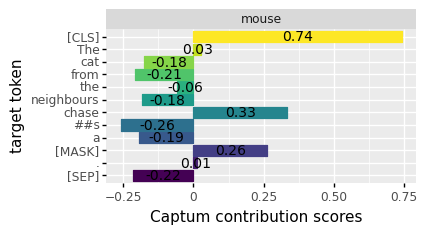

<ggplot: (8747594358435)>

Inside TransformerBlock backward

grad_input:  <class 'tuple'> 3
grad_input[0]:  <class 'torch.Tensor'>
grad_output:  <class 'tuple'> 1
grad_output[0]:  <class 'torch.Tensor'>

grad_input size: torch.Size([1, 11, 768])
grad_output size: torch.Size([1, 11, 768])
grad_input norm: tensor(1.8976)
SUMMARIZE
torch.Size([1, 11, 768])
torch.Size([11])
torch.Size([11])


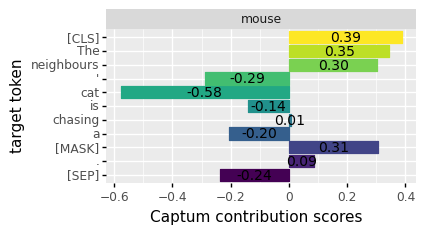

<ggplot: (8747594561549)>

CPU times: user 2.79 s, sys: 30.7 ms, total: 2.82 s
Wall time: 1.06 s


In [41]:
%%time
plotnine.options.figure_size = (4, 2)
#print("unknown token")
_ = run_and_show(f"The cat from the neighbours chases a {tokenizer.mask_token}.", ["mouse"])#, reference=[tokenizer.unk_token_id])
_ = run_and_show(f"The neighbours' cat is chasing a {tokenizer.mask_token}.", ["mouse"])#, reference=[tokenizer.unk_token_id])


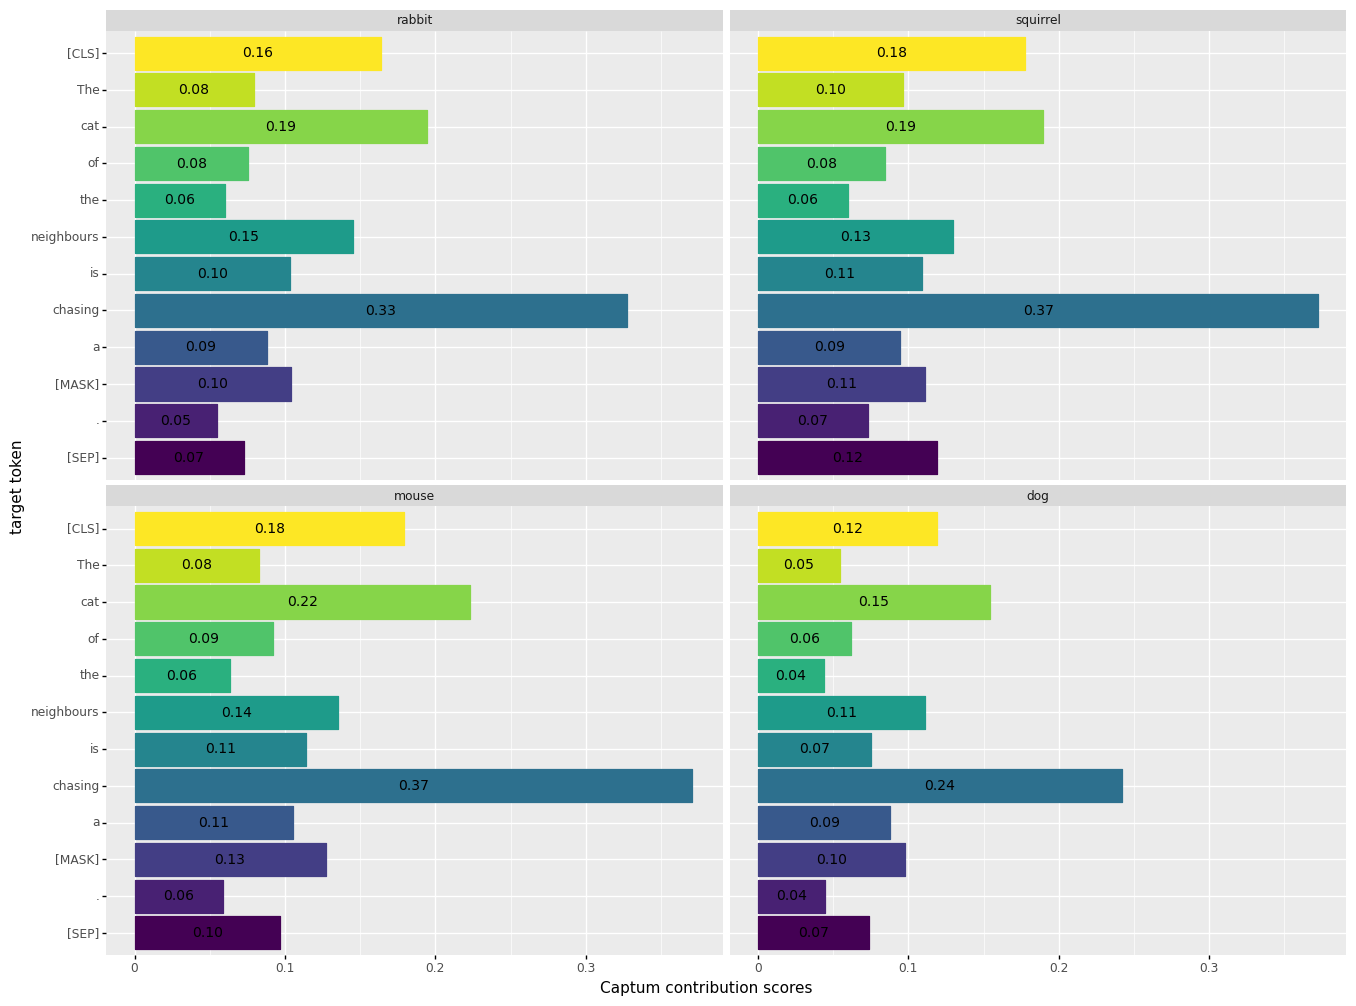

<ggplot: (8747590039037)>

In [18]:
plotnine.options.figure_size = (16,12)
_ = run_and_show(f"The cat of the neighbours is chasing a {tokenizer.mask_token}.", 4)